In [1]:
#importing Libraries

import numpy as np
import mahotas
import sklearn
import joblib
import cv2
import os
import glob


fixed_size             = tuple((500, 500))
train_path             = r"C:\Users\shubh\Cotton_Project\Disease_types"
bins                   = 8

In [2]:
def bgr_rgb(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img

def rgb_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img

In [3]:
# image segmentation

def img_segmentation(rgb_img,hsv_img):
    lower_green = np.array([25,0,20])
    upper_green = np.array([100,255,255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result

In [4]:
# feature-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-2: Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

# feature-3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [5]:
# Labels
label = os.listdir(train_path)

# sorting Labels
label.sort()
print(label)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

['Bacterial_blight', 'Curl_virus', 'Fussarium_wilt', 'Healthy']


In [6]:
# Getting through the data
for name in label:
    dir = os.path.join(train_path, name)

    # Current Label
    current_label = name

    # Getting list of all images
    for src in os.listdir(dir):
        # get the image file name
        file = dir + "\\" + src

        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        
        # Call for image function
        
        BGR_RGB       = bgr_rgb(image)
        RGB_HSV       = rgb_hsv(BGR_RGB)
        IMG_SEGMENT   = img_segmentation(BGR_RGB,RGB_HSV)

        # Call for Global Fetaures
        
        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
        fv_haralick   = fd_haralick(IMG_SEGMENT)
        fv_histogram  = fd_histogram(IMG_SEGMENT)
        
        # Concatenate 
        
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        
        

        # appending to list
        labels.append(current_label)
        global_features.append(global_feature)

    print("Processed folder: {}".format(current_label))

print("Completed Global Feature Extraction...")

Processed folder: Bacterial_blight
Processed folder: Curl_virus
Processed folder: Fussarium_wilt
Processed folder: Healthy
Completed Global Feature Extraction...


In [7]:
# get the overall feature vector size
print("Global featuressize {}".format(np.array(global_features).shape))

# get the overall training label size
print("Labels {}".format(np.array(labels).shape))

Global featuressize (1710, 532)
Labels (1710,)


In [8]:
# encode the target labels
from sklearn.preprocessing import LabelEncoder
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("Labels encoded...")

Labels encoded...


In [9]:
# scale features in the range (0-1)
from sklearn.preprocessing import MinMaxScaler
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("Global features normalized...")

Global features normalized...


In [10]:
print("Labels: {}".format(target))
print("Labels shape: {}".format(target.shape))

Labels: [0 0 0 ... 3 3 3]
Labels shape: (1710,)


In [11]:
# Model Training
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

warnings.filterwarnings('ignore')


num_trees = 100
test_size = 0.20
seed      = 7
scoring    = "accuracy"

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

In [12]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(rescaled_features,
                                                                                          target,
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("Train and Test data splitted...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape)) 

Train and Test data splitted...
Train data  : (1368, 532)
Test data   : (342, 532)


LR: 0.947368 
LDA: 0.950292 
KNN: 0.900585 
CART: 0.961988 
RF: 0.985380 
NB: 0.701754 
SVM: 0.926901 


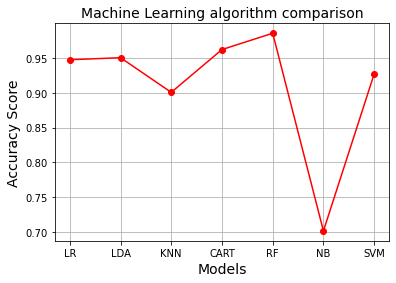

In [13]:
# Checking Accuracy for multiple models
for name, model in models:
    model.fit(trainDataGlobal, trainLabelsGlobal)
    y_predict=model.predict(testDataGlobal)
    res = accuracy_score(testLabelsGlobal, y_predict)
    results.append(res)
    names.append(name)
    msg = "%s: %f " % (name, res.mean())
    print(msg)
       
plt.plot(names, results, color='red', marker='o')
plt.title('Machine Learning algorithm comparison', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy Score', fontsize=14)
plt.grid(True)
plt.show()

In [14]:
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)
clf.fit(trainDataGlobal, trainLabelsGlobal)
y_predict=clf.predict(testDataGlobal)

In [15]:
# save the model to disk
filename = 'Disease_type_detection.sav'
joblib.dump(clf, filename)

['Disease_type_detection.sav']

In [16]:
cm = confusion_matrix(testLabelsGlobal,y_predict)

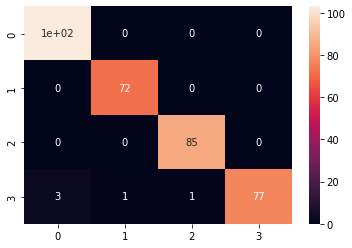

In [17]:
import seaborn as sns
sns.heatmap(cm ,annot=True)

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(testLabelsGlobal, y_predict)

0.9853801169590644

In [19]:
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(testDataGlobal, testLabelsGlobal)
print(result)

0.9853801169590644


In [20]:
for img in glob.glob(r'C:\Users\shubh\Cotton_Project\type_data\*.jpg'):
    image = cv2.imread(img)

    image = cv2.resize(image, fixed_size)

    # Call for image functions

    BGR_RGB       = bgr_rgb(image)
    RGB_HSV       = rgb_hsv(BGR_RGB)
    IMG_SEGMENT   = img_segmentation(BGR_RGB,RGB_HSV)

    # Call for Global Fetaure Descriptors

    fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
    fv_haralick   = fd_haralick(IMG_SEGMENT)
    fv_histogram  = fd_histogram(IMG_SEGMENT)

    # Concatenate 

    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    features = []
    features.append(global_feature)

    pred = loaded_model.predict(features)

    for i in pred:
        if i == 0:
            print('bacteria')
        elif i == 1:
            print('virus')
        elif i == 2:
            print('wilt')
        else:
            print('healthy')

bacteria
bacteria
virus
virus
virus
virus
wilt
wilt
wilt
wilt
healthy
healthy
healthy
healthy
bacteria
bacteria
